## <center>Analiza poziomu PM2.5 w afrykańskich miastach</center>
### Zespół:
<ol>
    <li style='font-size: 20px'>Hubert Kłosowski 242424</li>
    <li style='font-size: 20px'>Krzysztof Kolanek 242425</li>
    <li style='font-size: 20px'>Kamil Małecki 242464</li>
</ol>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Wczytanie danych

In [2]:
train = pd.read_csv('transform\\train.csv')
test = pd.read_csv('transform\\test.csv')

### Podział na zbiór treningowy i walidacyjny

In [3]:
from sklearn.model_selection import train_test_split


X, y = train.drop(columns=['pm2_5'], axis=1), train['pm2_5']
test_ids = test['id']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### Zapis predykcji

In [4]:
import os


def save_to_csv(y_pred, save_as):
    if 'result' not in os.listdir(os.getcwd()):
        os.mkdir('result')
    final_df = pd.concat([test_ids, pd.DataFrame.from_dict({'pm2_5': y_pred})], axis=1)
    final_df.to_csv(f'result\\{save_as}', index=False)

### <center>Optuna + lightGBM</center>

In [5]:
import lightgbm as lgb
import optuna
from sklearn.metrics import root_mean_squared_error


def define_lightgbm_model(trial):
    params = {
        'objective': 'root_mean_squared_error',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 40, 256),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 900, 1100),
        'tree_learner': 'voting',
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 50, 150),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
        'bagging_freq': 1,
        'device': 'cpu',
        'n_jobs': -1,
        'random_state': 4,
        'verbosity': -1
    }
    return lgb.LGBMRegressor(**params)

def objective_lightgbm(trial):
    model = define_lightgbm_model(trial)
    model.fit(X_train, y_train)
    return root_mean_squared_error(y_test, model.predict(X_test))

In [6]:
study_lightgbm = optuna.create_study(direction='minimize', study_name='AirQualityWithLightGBM', sampler=optuna.samplers.TPESampler())
study_lightgbm.optimize(objective_lightgbm, n_trials=100)

[I 2024-05-22 12:07:05,803] A new study created in memory with name: AirQualityWithLightGBM
[I 2024-05-22 12:07:07,091] Trial 0 finished with value: 10.196189086500148 and parameters: {'num_leaves': 126, 'max_depth': 18, 'learning_rate': 0.0004696611117391809, 'n_estimators': 1037, 'subsample': 0.5435287137716922, 'colsample_bytree': 0.937521149101253, 'min_data_in_leaf': 79, 'reg_lambda': 0.010660700437324587}. Best is trial 0 with value: 10.196189086500148.
[I 2024-05-22 12:07:08,452] Trial 1 finished with value: 6.726902155632166 and parameters: {'num_leaves': 64, 'max_depth': 15, 'learning_rate': 0.010163446323159898, 'n_estimators': 1093, 'subsample': 0.882206174297822, 'colsample_bytree': 0.8929958901665096, 'min_data_in_leaf': 149, 'reg_lambda': 0.0005141526019750909}. Best is trial 1 with value: 6.726902155632166.
[I 2024-05-22 12:07:10,038] Trial 2 finished with value: 5.8048732868752735 and parameters: {'num_leaves': 216, 'max_depth': 13, 'learning_rate': 0.03919711034803891,

### Zdefiniowanie najlepszego lightgbm

In [7]:
lgb_model = define_lightgbm_model(study_lightgbm.best_trial)
lgb_model.fit(X_train, y_train)
lightgbm_params = ['num_leaves', 'max_depth', 'learning_rate', 'n_estimators', 'subsample', 'colsample_bytree', 'min_data_in_leaf']
lgb_pred = lgb_model.predict(X_test)
root_mean_squared_error(y_test, lgb_pred)

5.706891418374839

### Krzywa nauki dla lightGBM

In [8]:
from sklearn.model_selection import LearningCurveDisplay


# LearningCurveDisplay.from_estimator(lgb_model, X, y, cv=20, n_jobs=-1, random_state=4, scoring='neg_root_mean_squared_error')

In [9]:
# params_12 =  {'num_leaves': 25, 
#            'max_depth': 15, 
#            'learning_rate': 0.01982093884782807, 
#            'n_estimators': 1042, 
#            'tree_learner': 'voting', 
#            'subsample': 0.8572357579881347, 
#            'colsample_bytree': 0.8692866219741755, 
#            'min_data_in_leaf': 57,
#            'bagging_freq': 1,
#             'device': 'cpu',
#             'n_jobs': -1,
#             'random_state': 4,
#             'verbosity': -1,
#            'objective': 'root_mean_squared_error',
#             'boosting_type': 'gbdt',
#            }
# best_lgbm = lgb.LGBMRegressor(**params_12)
# best_lgbm.fit(X, y)
# best_lgbm_pred = best_lgbm.predict(X_test)
# root_mean_squared_error(y_test, best_lgbm_pred)
# save_to_csv(best_lgbm.predict(test), 'check.csv')

### Wykres przedstawiający każdy <i>trial</i> w procesie nauki

In [10]:
optuna.visualization.plot_optimization_history(study_lightgbm)

### Wizualizacja przekroju parametrów

In [11]:
optuna.visualization.plot_slice(study_lightgbm, params=lightgbm_params)

### Wpływ poszczególnych parametrów na proces nauki modelu

In [12]:
optuna.visualization.plot_param_importances(study_lightgbm)

### Najlepsze parametry

In [13]:
study_lightgbm.best_params

{'num_leaves': 46,
 'max_depth': 12,
 'learning_rate': 0.05430359671258132,
 'n_estimators': 995,
 'subsample': 0.9266599683880067,
 'colsample_bytree': 0.9661332233855346,
 'min_data_in_leaf': 54,
 'reg_lambda': 8.491427443971236}

### Znaczenie poszczególnych kolumn

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

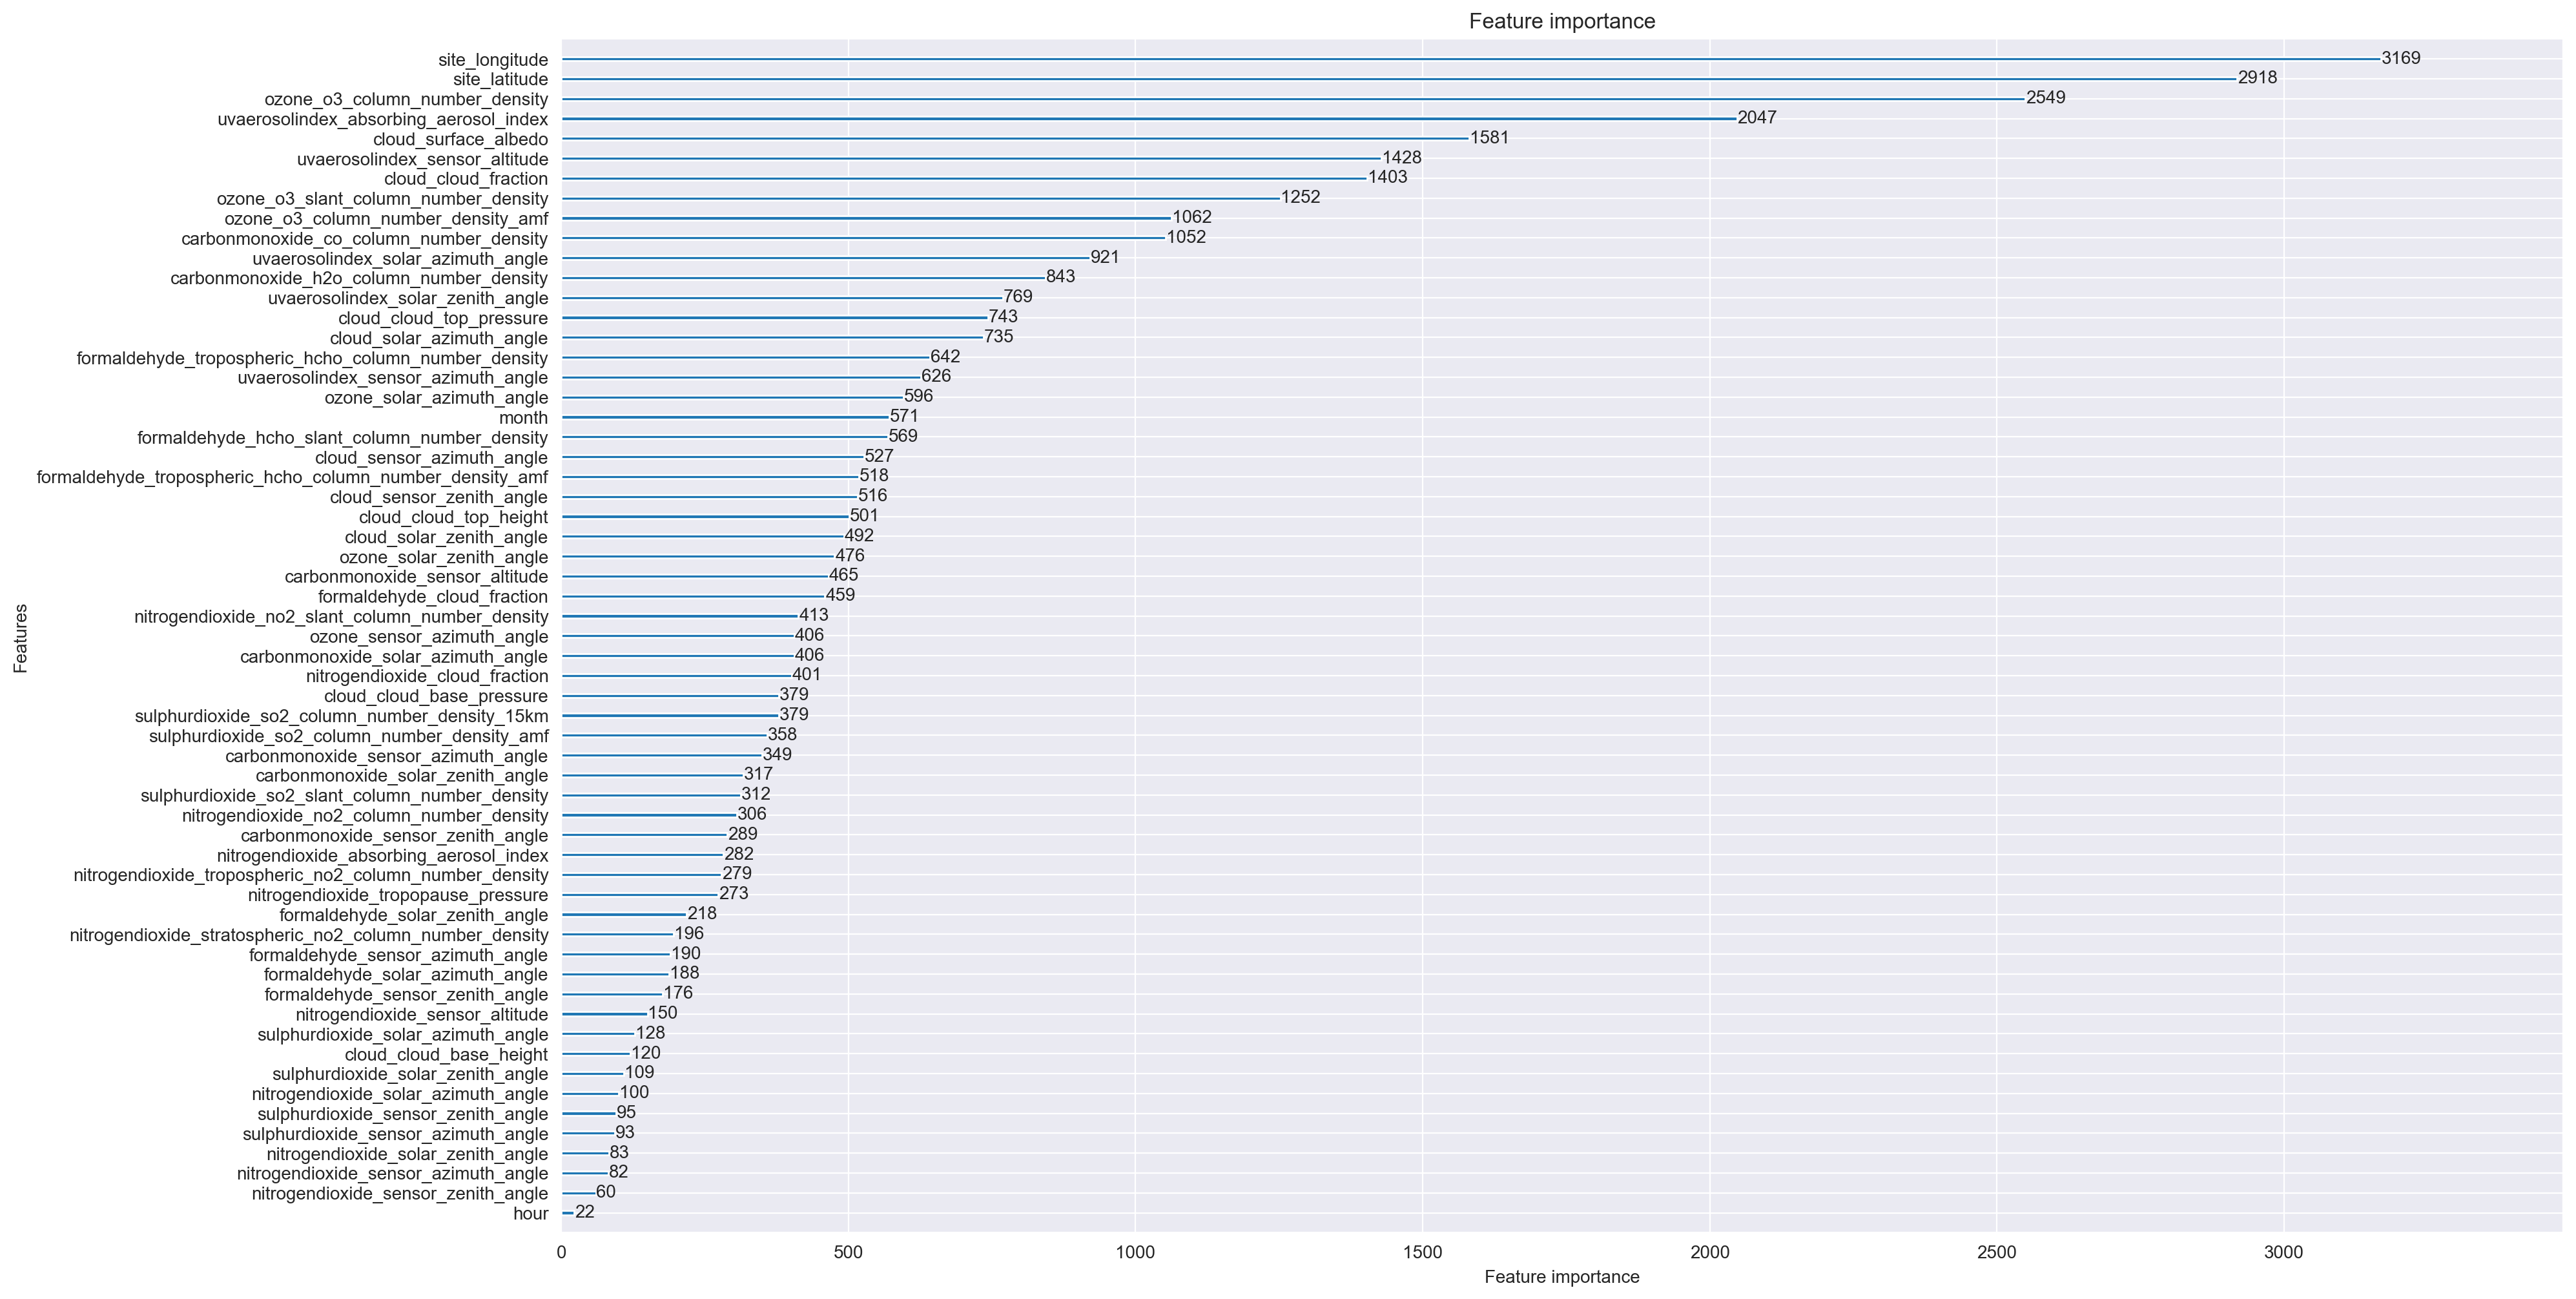

In [14]:
lgb.plot_importance(lgb_model, figsize=(20, 12), dpi=200)

### Drzewo decyzyjne dla lightGBM

<Axes: >

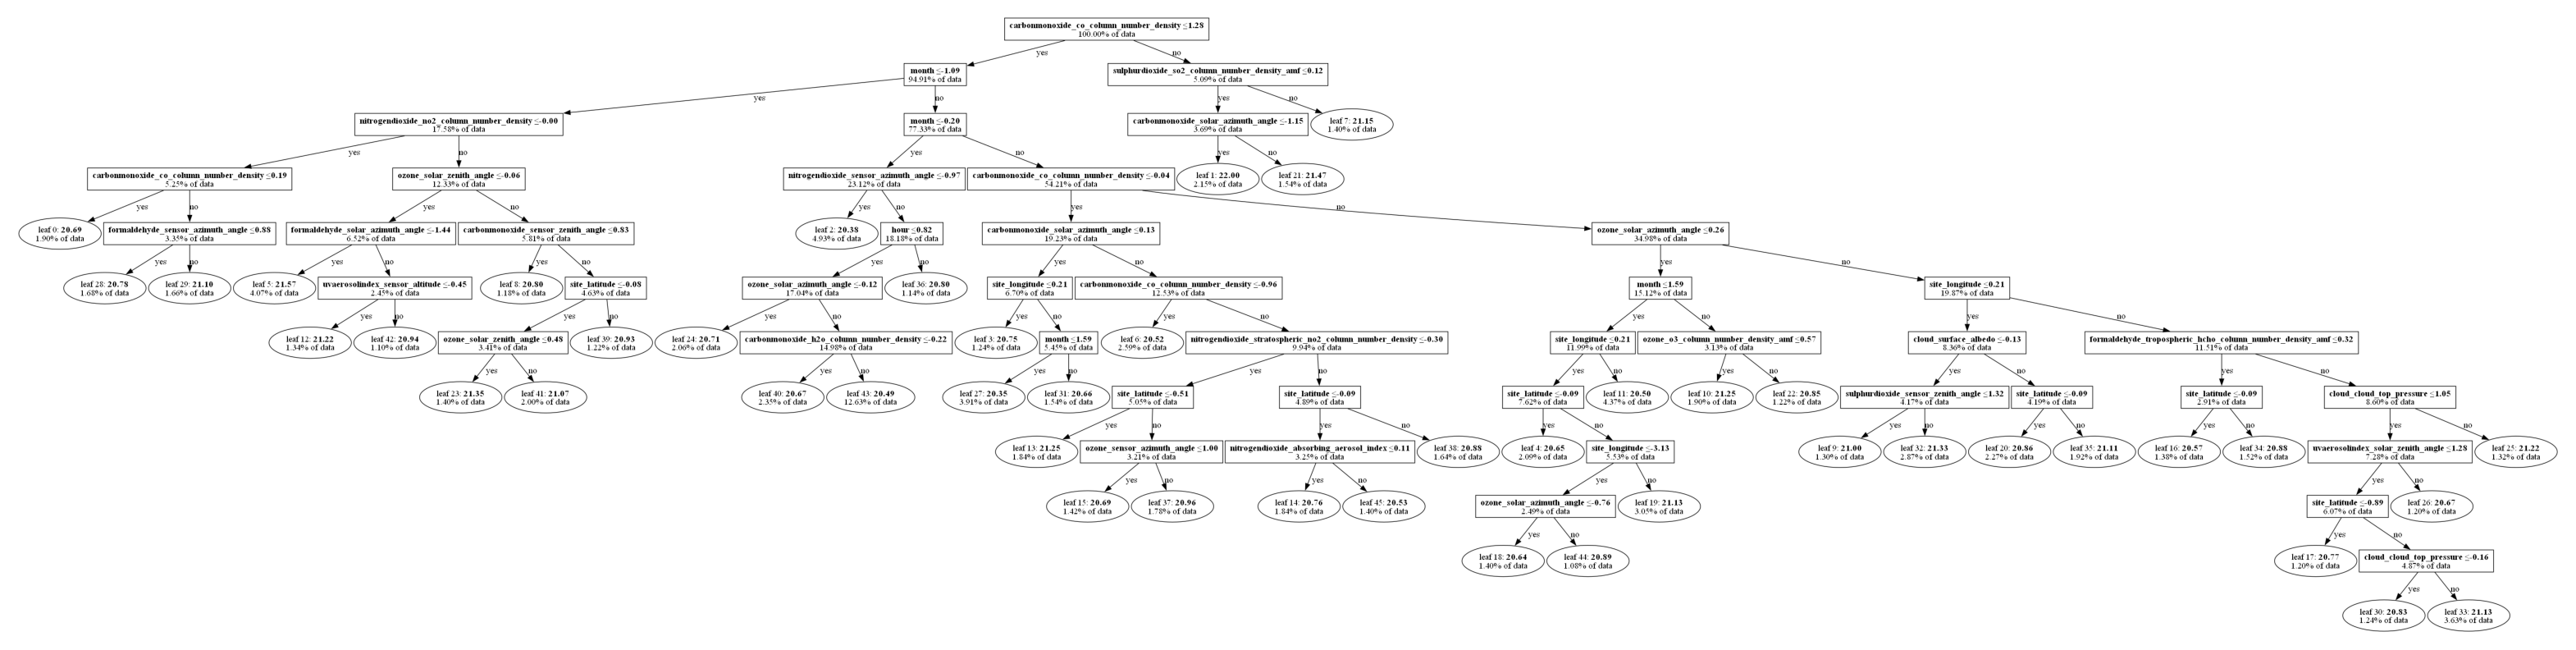

In [15]:
lgb.plot_tree(lgb_model, precision=2, figsize=(20, 12), show_info=['data_percentage'], dpi=200, orientation='vertical')

### Predykcje z lightGBM

In [16]:
save_to_csv(lgb_model.predict(test.drop(columns='id', axis=1)), 'lightgbm.csv')

### Dodatkowe informacje
<ol>
    <li>The 15km SO2 band is ingested only when solar_zenith_angle < 70.</li>
    <li>Because of noise on the data, negative vertical column values are often observed in particular over clean regions or for low SO2 emissions. It is recommended not to filter these values except for outliers, i.e. for vertical columns lower than -0.001 mol/m^2.</li>
    <li>The effective cloud fraction is the radiometric equivalent cloud fraction of a satellite pixel assuming a fixed cloud albedo, usually 0.8. By definition the effective cloud fraction times the assumed cloud albedo plus the cloud-free surface and atmosphere contributions yields a TOA reflectance that agrees with the observed TOA reflectance.</li>
</ol>